# 경희대학교 도서관 도서 추천시스템 : desKHU

바로가기 : https://khuda-deskhu.streamlit.app/

🗒️ requirements.txt
- langchain==0.0.240
- tiktoken==0.4.0
- openai==0.27.8
- pandas==1.5.3
- Requests==2.31.0
- scikit_learn==1.2.1
- selenium==4.10.0

In [1]:
from sklearn.metrics.pairwise import cosine_similarity
from langchain.chat_models import ChatOpenAI
from langchain.prompts.chat import (
    ChatPromptTemplate,
    SystemMessagePromptTemplate,
    HumanMessagePromptTemplate,
)
from langchain import LLMChain
from langchain.embeddings import OpenAIEmbeddings
import tiktoken
import os
import requests
import pandas as pd
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium import webdriver

- OPENAI API KEY 발급 : https://www.daleseo.com/chatgpt-api-keys/
- NAVER OPEN API KEY 사용법 : https://ai-creator.tistory.com/8

In [2]:
# your api key
openai_api_key = input("OPENAI_API_KEY : ")
client_id = input("X-Naver-Client-Id : ")
client_secret = input("X-Naver-Client-Secret : ")

OPENAI_API_KEY : 
X-Naver-Client-Id : 
X-Naver-Client-Secret : 


In [3]:
os.environ["OPENAI_API_KEY"] = openai_api_key

## 쿼리(키워드) 생성

In [4]:
def generate_query(interest, gpt):
    chat = ChatOpenAI(model=gpt, temperature=0.7, max_tokens=100)

    system_template = """
    You are an AI trained to generate korean keywords for book titles based on user prompts.
    Your goal is to return a list of unique keywords that are most relevant to the user's interests, specifically focusing on higher education level material. 
    Make sure each keyword is relevant to the topic of interest by combining the topic keyword with other relevant keywords. 
    For example, if the user inputs 'Want to enhance concentration', return a comma-separated string of keywords like 'Enhancement of Concentration, Concentration, Imemersion, Meditation, Stress Management,Productivity, Mindfulness'.
    """
    system_message_prompt = SystemMessagePromptTemplate.from_template(system_template)

    human_template = f"Generate keywords for the following interest: {interest}"
    human_message_prompt = HumanMessagePromptTemplate.from_template(human_template)

    chat_prompt = ChatPromptTemplate.from_messages([system_message_prompt, human_message_prompt])
    chain = LLMChain(llm=chat, prompt=chat_prompt)
    query = chain.run(interest=interest)

    return query

In [5]:
interest = "인간관계가 고민이야."
gpt = 'gpt-3.5-turbo'
k = 10 # 추천 결과의 개수

In [6]:
keywords = [keyword.strip() for keyword in generate_query(interest, gpt).split(",")]
keywords

['인간관계',
 '대인관계',
 '사회적 관계',
 '소통',
 '원활한 대화',
 '갈등 해결',
 '인간 행동',
 '사회 심리학',
 '사회적 지지',
 '사회적 네트워크']

## 도서 데이터 

생성된 쿼리를 바탕으로 해당 쿼리와 관련된 도서에 대한 데이터를 네이버 open api를 이용하여 받아왔다.

In [7]:
def book_data(query, display=30):
    naver_url = 'https://openapi.naver.com/v1/search/book.json'

    headers = {"X-Naver-Client-Id" : client_id, 
               "X-Naver-Client-Secret" : client_secret}
    
    params = {"query" : query,
              "display" : display}
    
    response = requests.get(naver_url, headers=headers, params=params)

    data = pd.DataFrame(response.json()['items'])

    return data

In [8]:
df = pd.concat([book_data(keyword) for keyword in keywords], ignore_index=True)
df = df[df['description'] != ''].reset_index(drop=True)
df

,title,link,image,author,discount,publisher,pubdate,isbn,description
0,데일 카네기 인간관계론(90주년 기념 개정증보판) (인간 본성을 성공철학으로 집대성...,https://search.shopping.naver.com/book/catalog...,https://shopping-phinf.pstatic.net/main_411012...,데일 카네기,18000,다산북스,20230712,9791130645452,“시대를 초월한다는 말로는 부족하다!”\n인간 본성을 성공철학으로 집대성한 불후의 ...
1,Give and Take(기브앤테이크) (주는 사람이 성공한다),https://search.shopping.naver.com/book/catalog...,https://shopping-phinf.pstatic.net/main_324634...,애덤 그랜트,15750,생각연구소,20130607,9788962605815,양보와 배려는 어떻게 성과로 이어지는가?\n\n주는 사람이 성공한다『Give and...
2,합리적 남자 (2030세대의 연애와 결혼에 대한 시대적 선택),https://search.shopping.naver.com/book/catalog...,https://shopping-phinf.pstatic.net/main_324427...,롤로 토마시,11700,아니마,20150915,9788996539360,작가는 인터넷 공간에서 롤로 토마시라는 필명으로 활동하며 전 세계에 수천만 명의 독...
3,데일 카네기 인간관계론 (무삭제 완역본),https://search.shopping.naver.com/book/catalog...,https://shopping-phinf.pstatic.net/main_410306...,데일 카네기,17100,와일드북,20230717,9791192412535,"데일 카네기 인간관계론\n1936년, 초판본 무삭제 완역본\n\n국내 최초 소장용\..."
4,사람을 얻는 지혜(국내 최초 스페인어 완역본) (국내 최초 스페인어 완역본),https://search.shopping.naver.com/book/catalog...,https://shopping-phinf.pstatic.net/main_354392...,발타자르그라시안,10800,현대지성,20221028,9791139708967,"니체, 쇼펜하우어가 극찬한, 인간 본성과 관계에 대한 최고의 통찰\n발타자르 그라시..."
...,...,...,...,...,...,...,...,...,...
202,세계를 만드는 커뮤니케이션 (세계사회와 네트워크의 사회적 영향),https://search.shopping.naver.com/book/catalog...,https://shopping-phinf.pstatic.net/main_324637...,노르베르트 볼츠,18000,한울아카데미,20091005,9788946051843,『세계를 만드는 커뮤니케이션』에서 우리는 뉴미디어 시대에 이루어지는 범세계적 커뮤니...
203,세계를 만드는 커뮤니케이션 (세계사회와 네트워크의 사회적 영향),https://search.shopping.naver.com/book/catalog...,https://shopping-phinf.pstatic.net/main_324381...,노르베르트 볼츠,13500,한울아카데미,20091005,9788946041714,『세계를 만드는 커뮤니케이션』에서 우리는 뉴미디어 시대에 이루어지는 범세계적 커뮤니...
204,도시 모빌리티 네트워크 (사회적 실천과 모빌리티의 정치학),https://search.shopping.naver.com/book/catalog...,https://shopping-phinf.pstatic.net/main_324363...,스벤 케셀링,13500,앨피,20200228,9791187430940,“도시는 도시 안에 고정되는 것이 아니라\n도시를 통해 흐르는 것으로 (재)생산되고...
205,네트워크의 부 (사회적 생산은 시장과 자유를 어떻게 바꾸는가),https://search.shopping.naver.com/book/catalog...,https://shopping-phinf.pstatic.net/main_324414...,요하이 벤클러,26100,커뮤니케이션북스,20150401,9791130435473,사회적 생산이란? 시장에 의존하지 않고 이루어지는 생산이다. 어떻게 가능한가? 소셜...


## 소장 정보

isbn을 이용하여 경희대학교 도서관에 해당 책에 대한 소장 정보를 크롤링으로 가져왔다.

In [9]:
import chromedriver_autoinstaller

chromedriver_autoinstaller.install()

def get_rent_status(isbn):
    url = f"https://kulis-primo.hosted.exlibrisgroup.com/primo-explore/search?query=any,contains,{isbn},AND&tab=default_tab&search_scope=default_scope&sortby=date&vid=82KHU_GLOBAL&lang=ko_KR&offset=0"

    options = webdriver.ChromeOptions()
    options.add_argument('headless')

    driver = webdriver.Chrome(options=options)
    driver.get(url)

    rentable = ''

    try:
        items = WebDriverWait(driver, 1).until(EC.presence_of_all_elements_located((By.CSS_SELECTOR, 'span.locations-link')))
        for item in items:
            rentable += item.text
    except:
        rentable = '소장정보 없음'
    finally:
        driver.quit()
    
    return rentable

CHROME > 106.0.5249.21, using mac_arm64


In [10]:
df['rentable'] = df['isbn'].apply(lambda x : get_rent_status(x))
df = df[df['rentable'] != '소장정보 없음']
df

,title,link,image,author,discount,publisher,pubdate,isbn,description,rentable
1,Give and Take(기브앤테이크) (주는 사람이 성공한다),https://search.shopping.naver.com/book/catalog...,https://shopping-phinf.pstatic.net/main_324634...,애덤 그랜트,15750,생각연구소,20130607,9788962605815,양보와 배려는 어떻게 성과로 이어지는가?\n\n주는 사람이 성공한다『Give and...,국제 중앙도서관자료열람실(158.2 G761g K )
4,사람을 얻는 지혜(국내 최초 스페인어 완역본) (국내 최초 스페인어 완역본),https://search.shopping.naver.com/book/catalog...,https://shopping-phinf.pstatic.net/main_354392...,발타자르그라시안,10800,현대지성,20221028,9791139708967,"니체, 쇼펜하우어가 극찬한, 인간 본성과 관계에 대한 최고의 통찰\n발타자르 그라시...",국제 중앙도서관자료열람실(868.3 G731o K5 )
14,화성 남자와 금성 여자를 넘어서 (차이를 넘어서 마음으로),https://search.shopping.naver.com/book/catalog...,https://shopping-phinf.pstatic.net/main_324543...,존 그레이,15120,김영사,20180914,9788934982357,"글로벌 베스트셀러 《화성에서 온 남자, 금성에서 온 여자》 존 그레이의 최신작!\n...",국제 중앙도서관자료열람실(306.7 G779b K )
16,나이 든 부모의 마음을 이해하는 대화 수업 (사랑하는 사람이 문득 낯설어진 당신을 ...,https://search.shopping.naver.com/book/catalog...,https://shopping-phinf.pstatic.net/main_324815...,데이비드 솔리,14400,반니,20210111,9791191214314,사랑하는 사람이 낯설어지는 순간이 있다. 굳이 내가 노력하지 않아도 누구보다 내 마...,서울 중앙도서관중앙자료실(153.60846 S686ㄴ )
17,연애동의 연애 불변의 법칙 (좋아하는 사람을 사로잡는 백전백승 연애 기술),https://search.shopping.naver.com/book/catalog...,https://shopping-phinf.pstatic.net/main_324804...,연애동,13500,빌리버튼,20191206,9791188545728,“제 연애는 왜 꼬일까요?” “엄청 잘해주는데 되레 귀찮다고 하네요” 등 주변에 연...,서울 중앙도서관중앙자료실(646.77 연63ㅇ )
...,...,...,...,...,...,...,...,...,...,...
196,인간 사회적 동물 (사회심리학에 관한 모든 것),https://search.shopping.naver.com/book/catalog...,https://shopping-phinf.pstatic.net/main_324669...,Robin Akert,24250,탐구당,20140410,9788964990179,우리는 세계나 국가와 같은 큰 집단 속에서 뿐만 아니라 가정과 같은 작은 집단 속에...,서울 중앙도서관중앙자료실(302 A769ㅇ11 )
197,지역 노인의 사회적 지지와 우울,https://search.shopping.naver.com/book/catalog...,https://shopping-phinf.pstatic.net/main_353020...,노병일,10800,다운샘,20050226,9788958171348,"본 책에서는 지역에 거주하는 노인이 가족 수준, 친구 수준, 지역사회 수준에서 제공...",서울 중앙도서관보존서고(362.6 노44ㅈ )
198,고통의 곁에 우리가 있다면 (재난 트라우마의 현장에서 사회적 지지와 연결을 생각하다),https://search.shopping.naver.com/book/catalog...,https://shopping-phinf.pstatic.net/main_373438...,채정호,16200,생각속의집,20230125,9791186118726,"코로나19, 이태원 참사, 재난 … \n고통은 우리를 어떻게 바꿔놓는가 \n“트라우...",서울 의학계열도서관의학자료실(616.8521 채74ㄱ )
204,도시 모빌리티 네트워크 (사회적 실천과 모빌리티의 정치학),https://search.shopping.naver.com/book/catalog...,https://shopping-phinf.pstatic.net/main_324363...,스벤 케셀링,13500,앨피,20200228,9791187430940,“도시는 도시 안에 고정되는 것이 아니라\n도시를 통해 흐르는 것으로 (재)생산되고...,서울 중앙도서관중앙자료실(307.76 E96ㄱ )


## 임베딩 및 유사도 계산

OpenAIEmbeddings를 통해 책 소개와 사용자의 관심사를 임베딩하고 유사도를 계산하여 관심사와 유사한 책을 찾았다.

In [11]:
def embed_doc(text):
    embeddings = OpenAIEmbeddings()
    
    max_tokens = 8191
    encoding_name = 'cl100k_base'

    encoding = tiktoken.get_encoding(encoding_name)
    tokens = encoding.encode(text)[:max_tokens]
    
    truncated_text = encoding.decode(tokens)

    query_result = embeddings.embed_query(truncated_text)

    return query_result

In [12]:
embeddings = OpenAIEmbeddings()

book_embeddings = {row['title'] : embed_doc(f"{row['description']}") for _, row in df.iterrows()}
student_embedding = embeddings.embed_query(interest)

In [13]:
def recommend_books(student_embedding, book_embedding, top_k=5, similarity_threshold=0.4):
    similarities = [(book_title, cosine_similarity([student_embedding], [book_embedding])) 
                  for book_title, book_embedding in book_embedding.items()]
    similarities.sort(key=lambda x: x[1], reverse=True)

    top_k_books = []
    for book_title, similarity in similarities:
        if similarity >= similarity_threshold and len(top_k_books) < top_k:
            top_k_books.append(book_title)

    return top_k_books, similarities

In [14]:
recommend_books, similarities = recommend_books(
        student_embedding,
        book_embeddings,
        top_k = k,
        similarity_threshold=0
    )

In [15]:
similarities

[('대인관계론', array([[0.85896625]])),
 ('내 마음도 몰라주는 당신 이유는 내 행동에 있다 (사회심리학자의 상담실)', array([[0.85267546]])),
 ('대인관계 심리학 (제2판)', array([[0.84983834]])),
 ('대인관계 의사소통 (끌림과 설렘으로 다가서는)', array([[0.84936167]])),
 ('인생 성공을 위한 대인관계법 (성공을 원한다면 대인관계에 승부를 걸어라)', array([[0.84780383]])),
 ('대인관계 심리학', array([[0.84663786]])),
 ('데일 카네기 인간관계론 (무삭제 완역본)', array([[0.84324312]])),
 ('사회적 우울증 (사회적 관계에서 오는 현대인의 마음의 병 신종 우울증을 해부한다)', array([[0.84009975]])),
 ('인간행동과 사회환경 (제4판)', array([[0.83698559]])),
 ('굿바이 갈등 (갈등 해결을 위한 소통의 인간관계 기술)', array([[0.83601442]])),
 ('인간행동과 사회환경', array([[0.83516406]])),
 ('인간 사회적 동물 (사회심리학에 관한 모든 것)', array([[0.83480049]])),
 ('사회심리학 (마음과 행동을 결정하는 사회적 상황의 힘)', array([[0.83452099]])),
 ('연애동의 연애 불변의 법칙 (좋아하는 사람을 사로잡는 백전백승 연애 기술)', array([[0.83203831]])),
 ('인간행동', array([[0.82749105]])),
 ('건강설계 가족 및 사회적 관계', array([[0.82646488]])),
 ('나는 왜 저 인간에게 휘둘릴까? (이 세상 모든 민폐 인간들로부터 나를 지키는 기술)', array([[0.82582242]])),
 ('갈등 해결의 지혜', array([[0.8236812]])),
 ('외국인 노동자의 노사관계와 사회적 적응         

## 추천 결과

In [16]:
recommendation = df[df['title'].isin(recommend_books)].reset_index(drop=True)
recommendation

,title,link,image,author,discount,publisher,pubdate,isbn,description,rentable
0,데일 카네기 인간관계론 (무삭제 완역본),https://search.shopping.naver.com/book/catalog...,https://shopping-phinf.pstatic.net/main_324381...,데일 카네기,10350,현대지성,20191007,9791187142560,사람의 마음을 사로잡는 가장 빠르고 확실한 방법!\n데일 카네기가 전하는 성공하는 ...,국제 중앙도서관자료열람실(158.1 C289h K32 )
1,대인관계론,https://search.shopping.naver.com/book/catalog...,https://shopping-phinf.pstatic.net/main_334359...,안범희,17460,태영출판사,20100310,9788963020211,"『대인관계론』. 이 책은 적절한 대인관계를 위한 인간 행동의 이해, 대화를 비롯한 ...",서울 중앙도서관중앙자료실(158.2 안44ㄷ )
2,대인관계 의사소통 (끌림과 설렘으로 다가서는),https://search.shopping.naver.com/book/catalog...,https://shopping-phinf.pstatic.net/main_324613...,신민주^주용국,13500,학지사,20190225,9788999719226,▶ 이 책은 대인관계 의사소통을 다룬 이론서입니다.,서울 중앙도서관보존서고(153.6 신38ㄷ )
3,대인관계 심리학,https://search.shopping.naver.com/book/catalog...,https://shopping-phinf.pstatic.net/main_324975...,김원경,24750,피앤씨미디어,20190820,9791157306978,『대인관계 심리학』은 저자가 지난 십여 년 간 동일한 제목의 강의를 맡아 진행해오면...,서울 중앙도서관중앙자료실(158.2 김66ㄷㄱ )
4,대인관계 심리학 (제2판),https://search.shopping.naver.com/book/catalog...,https://shopping-phinf.pstatic.net/main_324871...,함승애,18000,양서원(박철용),20190720,9788999409158,대인관계의 의미와 중요성에 대해 더 쉽게 이해할 수 있도록 서술한 개정판이다. 대인...,서울 중앙도서관중앙자료실(158.2 함57ㄷ2 )
5,인생 성공을 위한 대인관계법 (성공을 원한다면 대인관계에 승부를 걸어라),https://search.shopping.naver.com/book/catalog...,https://shopping-phinf.pstatic.net/main_324966...,데일 카네기,10800,다문,20131015,9788971460450,상대방의 본질을 이해하면 좋은 인간관계를 가질 수 있다!\n\n성공을 원한다면 대인...,서울 중앙도서관중앙자료실(158.2 C289ㄱ )
6,사회적 우울증 (사회적 관계에서 오는 현대인의 마음의 병 신종 우울증을 해부한다),https://search.shopping.naver.com/book/catalog...,https://shopping-phinf.pstatic.net/main_324669...,사이토 다마키,0,한문화,20121129,9788956991474,"이 책에서는 사회 전반적인 환경에서 신종 우울증의 원인을 짚어보고, ‘자기애’가 발...",국제 중앙도서관제1보존서고(E41-378 )
7,굿바이 갈등 (갈등 해결을 위한 소통의 인간관계 기술),https://search.shopping.naver.com/book/catalog...,https://shopping-phinf.pstatic.net/main_324935...,양광모,0,청년정신,20101030,9788958611158,열 명의 친구보다 한 명의 적을 만들지 않는 것이 중요하다\n\n『굿바이 갈등』은 ...,국제 중앙도서관제1보존서고(D17-237 )
8,인간행동과 사회환경 (제4판),https://search.shopping.naver.com/book/catalog...,https://shopping-phinf.pstatic.net/main_350645...,장수한^김현주^임혁^채인숙,18000,공동체,20221011,9791167251657,이 책은 사회복지학을 다룬 이론서이다. 인간행동과 사회환경의 기조적이고 전반적인 내...,서울 중앙도서관중앙자료실(302 장56ㅇ4 )
9,내 마음도 몰라주는 당신 이유는 내 행동에 있다 (사회심리학자의 상담실),https://search.shopping.naver.com/book/catalog...,https://shopping-phinf.pstatic.net/main_325045...,전우영,11700,21세기북스,20120515,9788950936693,"『내 마음도 몰라주는 당신, 이유는 내 행동에 있다』는 오늘날 다양한 사회현상들 속...",국제 중앙도서관제2보존서고(GZ16-02 )


1
데일 카네기 인간관계론 (무삭제 완역본)


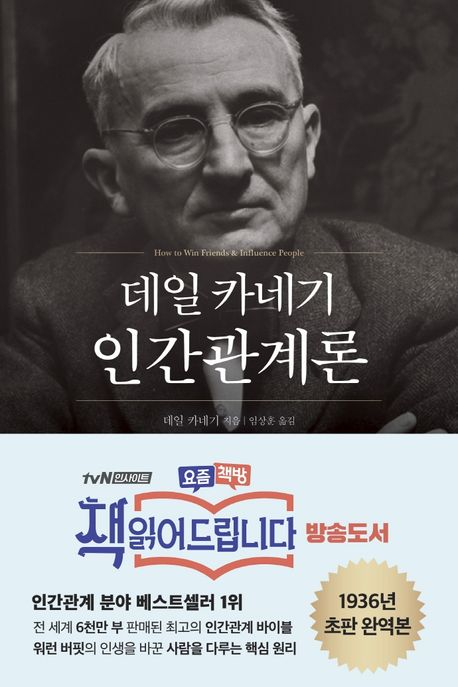

국제 중앙도서관자료열람실(158.1 C289h K32 )
https://kulis-primo.hosted.exlibrisgroup.com/primo-explore/search?query=any,contains,9791187142560,AND&tab=default_tab&search_scope=default_scope&sortby=date&vid=82KHU_GLOBAL&lang=ko_KR&offset=0


2
대인관계론


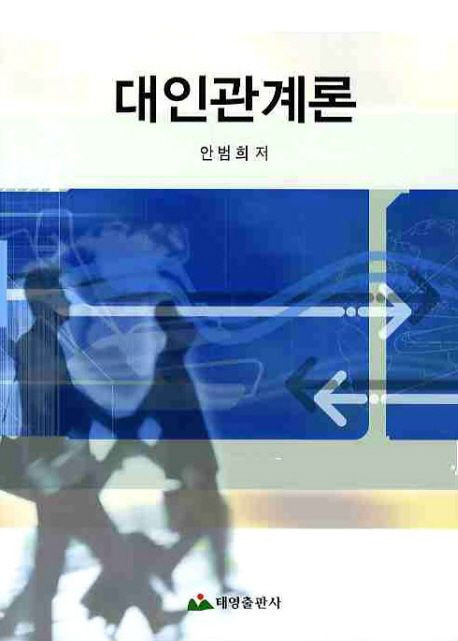

서울 중앙도서관중앙자료실(158.2 안44ㄷ )
https://kulis-primo.hosted.exlibrisgroup.com/primo-explore/search?query=any,contains,9788963020211,AND&tab=default_tab&search_scope=default_scope&sortby=date&vid=82KHU_GLOBAL&lang=ko_KR&offset=0


3
대인관계 의사소통 (끌림과 설렘으로 다가서는)


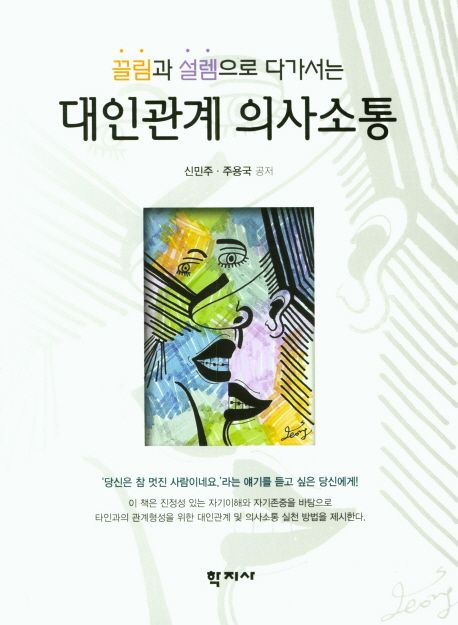

서울 중앙도서관보존서고(153.6 신38ㄷ )
https://kulis-primo.hosted.exlibrisgroup.com/primo-explore/search?query=any,contains,9788999719226,AND&tab=default_tab&search_scope=default_scope&sortby=date&vid=82KHU_GLOBAL&lang=ko_KR&offset=0


4
대인관계 심리학


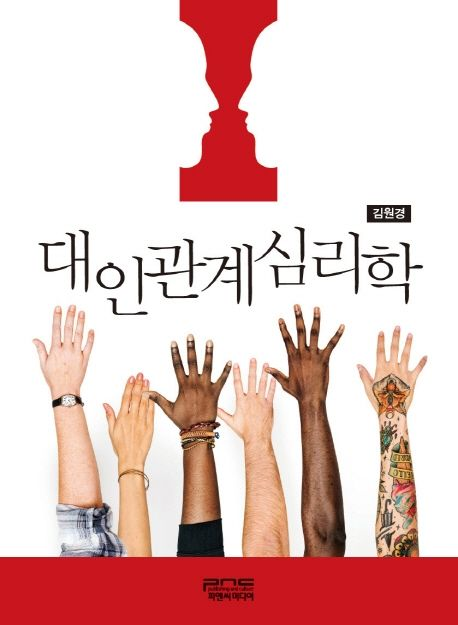

서울 중앙도서관중앙자료실(158.2 김66ㄷㄱ )
https://kulis-primo.hosted.exlibrisgroup.com/primo-explore/search?query=any,contains,9791157306978,AND&tab=default_tab&search_scope=default_scope&sortby=date&vid=82KHU_GLOBAL&lang=ko_KR&offset=0


5
대인관계 심리학 (제2판)


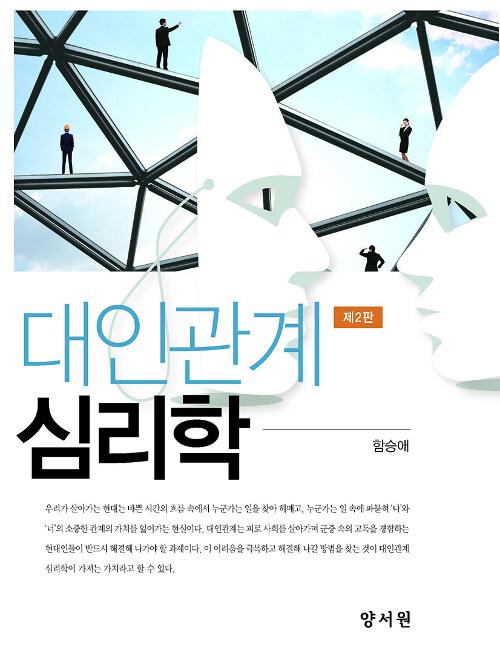

서울 중앙도서관중앙자료실(158.2 함57ㄷ2 )
https://kulis-primo.hosted.exlibrisgroup.com/primo-explore/search?query=any,contains,9788999409158,AND&tab=default_tab&search_scope=default_scope&sortby=date&vid=82KHU_GLOBAL&lang=ko_KR&offset=0


6
인생 성공을 위한 대인관계법 (성공을 원한다면 대인관계에 승부를 걸어라)


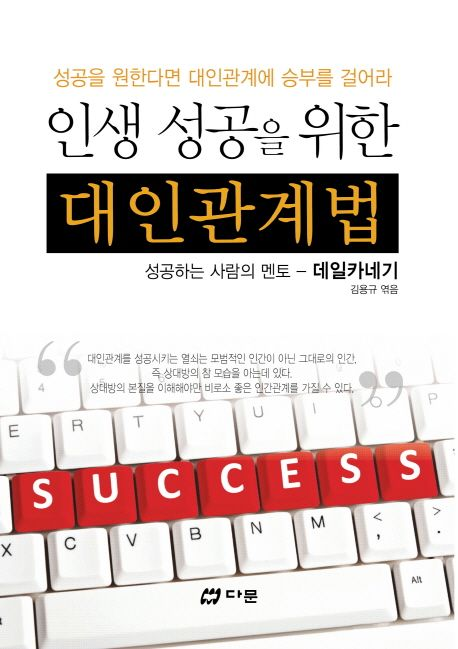

서울 중앙도서관중앙자료실(158.2 C289ㄱ )
https://kulis-primo.hosted.exlibrisgroup.com/primo-explore/search?query=any,contains,9788971460450,AND&tab=default_tab&search_scope=default_scope&sortby=date&vid=82KHU_GLOBAL&lang=ko_KR&offset=0


7
사회적 우울증 (사회적 관계에서 오는 현대인의 마음의 병 신종 우울증을 해부한다)


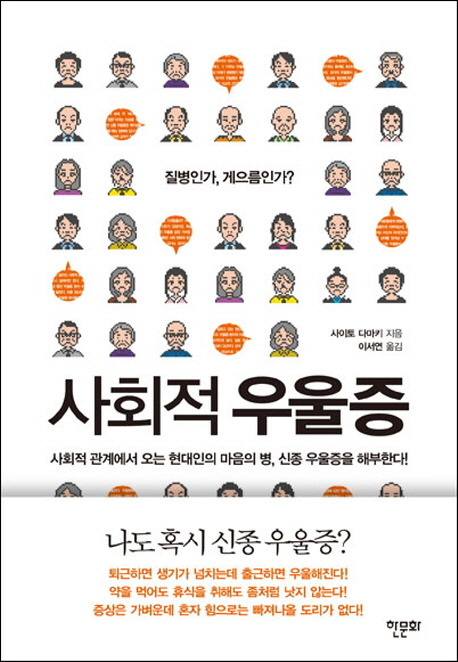

국제 중앙도서관제1보존서고(E41-378 )
https://kulis-primo.hosted.exlibrisgroup.com/primo-explore/search?query=any,contains,9788956991474,AND&tab=default_tab&search_scope=default_scope&sortby=date&vid=82KHU_GLOBAL&lang=ko_KR&offset=0


8
굿바이 갈등 (갈등 해결을 위한 소통의 인간관계 기술)


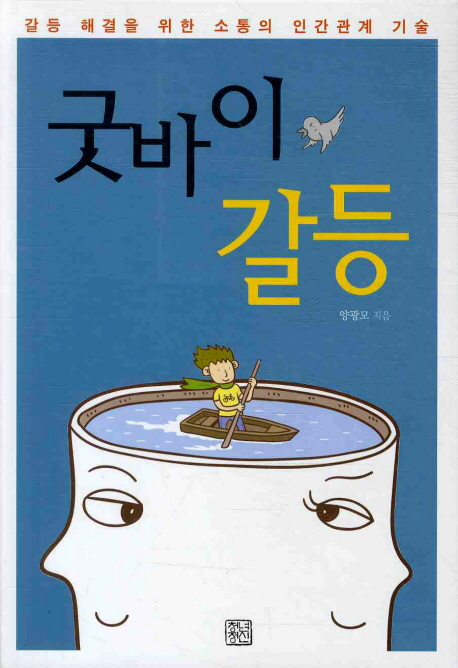

국제 중앙도서관제1보존서고(D17-237 )
https://kulis-primo.hosted.exlibrisgroup.com/primo-explore/search?query=any,contains,9788958611158,AND&tab=default_tab&search_scope=default_scope&sortby=date&vid=82KHU_GLOBAL&lang=ko_KR&offset=0


9
인간행동과 사회환경 (제4판)


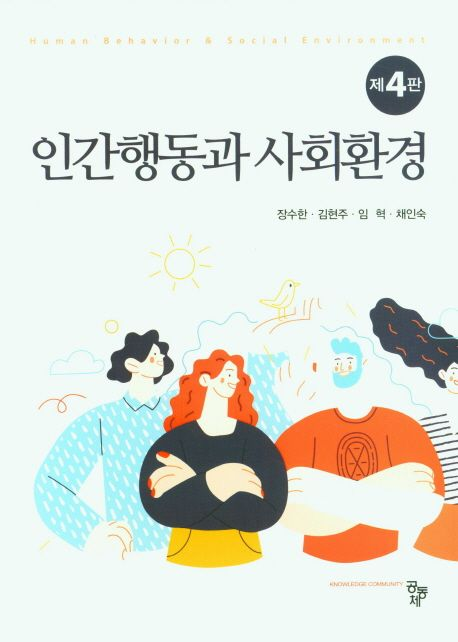

서울 중앙도서관중앙자료실(302 장56ㅇ4 )
https://kulis-primo.hosted.exlibrisgroup.com/primo-explore/search?query=any,contains,9791167251657,AND&tab=default_tab&search_scope=default_scope&sortby=date&vid=82KHU_GLOBAL&lang=ko_KR&offset=0


10
내 마음도 몰라주는 당신 이유는 내 행동에 있다 (사회심리학자의 상담실)


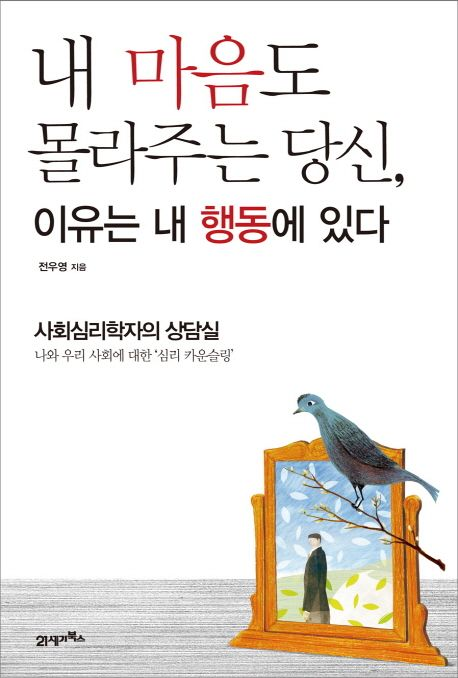

국제 중앙도서관제2보존서고(GZ16-02 )
https://kulis-primo.hosted.exlibrisgroup.com/primo-explore/search?query=any,contains,9788950936693,AND&tab=default_tab&search_scope=default_scope&sortby=date&vid=82KHU_GLOBAL&lang=ko_KR&offset=0




In [17]:
import IPython.display as display

for idx, row in recommendation.iterrows():
    print(idx+1)
    print(row['title'])
    image = display.Image(row['image'], width=200)
    display.display(image)
    print(row['rentable'])
    print('https://kulis-primo.hosted.exlibrisgroup.com/primo-explore/search?query=any,contains,{},AND&tab=default_tab&search_scope=default_scope&sortby=date&vid=82KHU_GLOBAL&lang=ko_KR&offset=0'.format(row['isbn']))
    print('\n')